In [1]:
cfg = dict(
    seq_length  = 160,
    d_model     = 256,
    latent_dim  = 64,   # latent dimension
    n_head      = 8,
    enc_layers  = 7,
    dec_layers  = 7,
    ff_dim      = 1024,
    dropout     = 0.05,
    emb_dropout = 0.05,

    # special token indices (match your vocabulary)
    pad_idx     = 0,
    sos_idx     = 2,
    eos_idx     = 3,
    # -------- regularization tweaks --------
    label_smoothing = 0.02,   # 0.0 to disable
    corruption_p     = 0.05,  # word-dropout on decoder inputs (train only)

    # -------- validation / decoding --------
    beam_every  = 5,   # run beam metrics every N epochs
    beam_size   = 5)

In [2]:
import torch, torch.nn as nn
import model_bs as mdl
import data_utils as du

# --- paths/config you already have ---
vocab_path   = "/home/md_halim_mondol/LSTM_VAE_Paper/vocab.json"
ckpt_path    = "/home/md_halim_mondol/LSTM_VAE_Paper/checkpoints/best_model.pth"
Dye_csv     = "/home/md_halim_mondol/Data/cleaned_voc_dye.csv"
test_csv     = "/home/md_halim_mondol/Data/Test.csv"

# cfg should already be defined; using its fields:
# cfg["seq_length"], ["d_model"], ["latent_dim"], ["pad_idx"], ["sos_idx"], ["eos_idx"],
# ["enc_layers"], ["dec_layers"], ["n_head"], ["dropout"], ["ff_dim"], ["beam_size"]

# --- load vocab ---
token_to_idx, idx_to_token = du.load_or_create_vocabulary(csv_paths=[], cache_path=vocab_path, test_smiles=None)
assert token_to_idx["<PAD>"] == cfg["pad_idx"]
assert token_to_idx["<SOS>"] == cfg["sos_idx"]
assert token_to_idx["<EOS>"] == cfg["eos_idx"]

# --- build the same architecture you trained ---
model = mdl.LSTM_VAE_Trans(
    vocab_size=len(token_to_idx),
    d_model=cfg["d_model"],
    latent_dim=cfg["latent_dim"],
    pad_idx=cfg["pad_idx"],
    sos_idx=cfg["sos_idx"],
    eos_idx=cfg["eos_idx"],
    enc_layers=cfg["enc_layers"],
    dec_layers=cfg["dec_layers"],
    nhead=cfg["n_head"],
    dropout=cfg["dropout"],
    max_len=cfg["seq_length"],
    dim_feedforward=cfg["ff_dim"])

# --- load weights robustly (handles 'module.' prefixes if any) ---
state = torch.load(ckpt_path, map_location="cpu")
try:
    model.load_state_dict(state, strict=True)
except RuntimeError:
    # remove a leading 'module.' if the checkpoint came from DataParallel
    from collections import OrderedDict
    new_state = OrderedDict()
    for k, v in state.items():
        new_state[k.replace("module.", "", 1)] = v
    model.load_state_dict(new_state, strict=True)

# --- device & optional DataParallel for speed (not required) ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Trainable params:", du.count_parameters(model))
print(f"Encoder parameters: {du.count_parameters(model.encoder)}")
model.eval()

# If you want to keep everything single-GPU-friendly for beam_search, DON'T wrap in DataParallel.
# If you DO wrap, remember to pass model.module to functions that call custom methods.

[vocab] loaded cached vocabulary from /home/md_halim_mondol/LSTM_VAE_Paper/vocab.json (69 tokens)


/var/tmp/ipykernel_32947/2225161562.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location="cpu")


Trainable params: 10246597
Encoder parameters: 2786048


LSTM_VAE_Trans(
  (encoder): EncoderBiLSTM(
    (emb): Embedding(69, 256, padding_idx=0)
    (emb_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (emb_do): Dropout(p=0.1, inplace=False)
    (lstm): LSTM(256, 128, num_layers=7, batch_first=True, dropout=0.05, bidirectional=True)
    (out_do): Dropout(p=0.05, inplace=False)
    (seq_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pool_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (to_mu): Linear(in_features=256, out_features=64, bias=True)
  (to_logvar): Linear(in_features=256, out_features=64, bias=True)
  (latent_to_token): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (emb): Embedding(69, 256, padding_idx=0)
    (emb_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pe): PositionalEncoding(
      (dropout): Dropout(p=0.05, inplace=False)
    )

In [3]:
import pandas as pd
from inference import reconstruct_smiles_table
import metrics as met

# Use the *unwrapped* model object for beam_search
m = model  # (if you ever wrap with DataParallel, use: model.module)

df_rec = reconstruct_smiles_table( smiles_list=None, test_csv=test_csv, model=m, token_to_idx=token_to_idx, idx_to_token=idx_to_token, seq_length=cfg["seq_length"], pad_idx=cfg["pad_idx"], sos_idx=cfg["sos_idx"], eos_idx=cfg["eos_idx"], device=device, mode="beam", beam_size=cfg["beam_size"], smiles_columns='smiles')

# show a preview
display(df_rec.head(10))

/home/md_halim_mondol/anaconda3/envs/cheminf/lib/python3.10/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


,input,reconstructed,valid,lev
0,CCOC(=O)C1(CC2CC2)CC[NH+]([C@@H](C)CCC2=c3cccc...,CCOC(=O)C1(CC2CC2)C[NH+](C[C@@H](C)CCC2=c3cccc...,yes,2
1,O=C(N[C@@H]1CCN(CC(F)(F)F)C1=O)c1c[nH]c2cccc(F...,O=C(N[C@@H]1CCN(CC(F)(F)F)C1=O)c1c[nH]c2cccc(F...,yes,0
2,Cc1ccc(C[NH+]2CCC[C@@H]2c2ccc(C(=O)Nc3nc(C)n(C...,Cc1ccc(C[NH+]2CCC[C@@H]2c2ccc(C(=O)Nc3nc(C)n(C...,no,3
3,O=C(C[C@@H]1C(=O)N=C2[N-]c3ccccc3N21)Nc1cccc(O...,O=C(C[C@@H]1C(=O)N=C2Sc3ccccc3N21)Nc1cccc(OC(F...,yes,4
4,CCc1ccc(-c2nc(CSc3nnnn3C3CC3)cs2)cc1,CCc1ccc(-c2nc(CSc3nnnn3C3CC3)cs2)cc1,yes,0
5,C[C@H]1CN(C(=O)N[C@@H](C)c2cccc(Br)c2)CCO1,C[C@H]1CN(C(=O)N[C@@H](C)c2cccc(Br)c2)CCO1,yes,0
6,Cc1ccn(C)c1[C@](O)(C(=O)[O-])C(F)(F)F,Cc1ccn(C)c1[C@](O)(C(=O)[O-])C(F)(F)F,yes,0
7,CC(C)N(C[C@@H]1CCCCO1)C(=O)[C@H]1CCc2n[nH]c(C(...,CC(C)N(C[C@@H]1CCCCO1)C(=O)[C@H]1CCc2n[nH]c(C(...,yes,0
8,N[C@H]1C=C[C@H](c2nnc3c(Cl)cc(C(F)(F)F)cn23)C1,N[C@H]1C=C[C@H](c2nnc3c(Cl)cc(C(F)(F)F)cn32)C1,yes,2
9,CC[C@@H](C)N(Cc1c(-c2ccccc2F)noc1N1CCOCC1)C(=O...,CC[C@@H](C)N(Cc1c(-c2ccccc2F)noc1N1CCOCC1)c1ccco1,yes,5


In [4]:
Dye_smiles = [
'CC1=CC(=O)c2c(Br)cc(Br)c(S(=O)(=O)O)c2C1=O',
'Cc1c(Br)cc(Br)c(C(C)c2ccc(C(C)C)c(Br)c2O)c1S(=O)(=O)O',
'Cc1ccccc1N=Nc1ccc(C(N)=O)cc1',
'Cc1ccc(-c2cccc(O)c2C(C)c2ccc(S(=O)(=O)O)cc2)cc1',
'CN(C)c1ccc2c(c1)CN=C2c1ccccc1',
'O=C1c2ccccc2C(=O)c2c(O)cccc21',
'O=C1Nc2ccccc2S(=O)(=O)[N-]c2c1cccc2S(=O)(=O)[O-]',
'CN(C)C1=CS(=O)(=O)c2ccc(N(C)C)cc21',
'CN(C)c1ccc(C(C)(c2ccc(N(C)C)cc2)c2ccc(N(C)C)cc2)cc1',
'Cc1ccc(C(c2ccc(O)cc2)(c2ccc(O)cc2)c2ccc(C(C)C)cc2)cc1',
'CN(C)c1ccc2c(c1)CC1=CC(=[N+](C)C)C(=N2)C=C1',
'O=C1c2cc(=O)cccc2C(=O)c2c(Br)cc(Br)cc21',
'O=c1cc(O)ccc(-c2ccc3c(oc(=O)c4ccccc43)c2O)c1']

In [5]:

df_rec = reconstruct_smiles_table(
    smiles_list=Dye_csv,
    test_csv=None,
    model=m,
    token_to_idx=token_to_idx,
    idx_to_token=idx_to_token,
    seq_length=cfg["seq_length"],
    pad_idx=cfg["pad_idx"],
    sos_idx=cfg["sos_idx"],
    eos_idx=cfg["eos_idx"],
    device=device,
    mode="beam",
    beam_size=cfg["beam_size"],
    smiles_columns='Dye')

# show a preview
display(df_rec.head(50))

/home/md_halim_mondol/anaconda3/envs/cheminf/lib/python3.10/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


,input,reconstructed,valid,lev
0,O=S1(=O)OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(...,O=S1(=O)OC(c2cc(Br)c(O)c(Br)c2)=c2c(cc(Br)c(O)...,no,8
1,O=S1(=O)OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(...,O=S1(=O)OC(c2cc(Br)c(O)c(O)c2)=c2c(cc(Br)c(Br)...,no,13
2,O=S1(=O)OC(c2cc(I)c(O)c(I)c2)(c2cc(I)c(O)c(I)c...,O=S1(=O)NC(c2cc(O)c(Cl)c(C)c2)c2cc(O)c(O)c(I)c...,no,7
3,O=S1(=O)OC(c2cc(Cl)c(O)c(Br)c2)(c2cc(Cl)c(O)c(...,O=S1(=O)OC(c2cc(Cl)c(O)c(O)c2)=c2c(cc(Cl)c(O)c...,no,10
4,Cc1c(C2(c3cc(Br)c(O)c(Br)c3C)OS(=O)(=O)c3ccccc...,Cc1c(C2(c3cc(Br)c(O)cc3[O-])C(=O)Oc3ccc(Br)cc3...,yes,26
5,O=S1(=O)OC(c2ccc(O)c(Cl)c2)(c2ccc(O)c(Cl)c2)c2...,O=S1(=O)OC(c2ccc(O)c(Cl)c2)[C@H](c2ccc(Cl)c(O)...,yes,9
6,O=S1(=O)OC(c2ccc(O)c(Br)c2)(c2ccc(O)c(Br)c2)c2...,O=S1(=O)OC(c2ccc(O)c(Br)c2)(c2ccc(O)c(Br)c2)c2...,yes,0
7,Cc1cc(C2(c3cc(C)c(O)c(Br)c3)OS(=O)(=O)c3ccccc3...,Cc1cc(C2(c3cc(C)c(O)c(Br)c3)OS(=O)(=O)c3ccccc3...,yes,0
8,Cc1cc(C2(c3cc(C)c(O)c(Br)c3C)OS(=O)(=O)c3ccccc...,Cc1cc(C2(c3cc(O)c(C)cc3[O-])C(=O)Oc3ccc(Br)cc3...,yes,23
9,O=S1(=O)OC(c2ccc(O)cc2)(c2ccc(O)cc2)c2ccccc21,O=S1(=O)OC(c2ccc(O)cc2)(c2ccc(O)cc2)c2ccccc21,yes,0


Found 13 novel dye reconstructions with lev > 0.


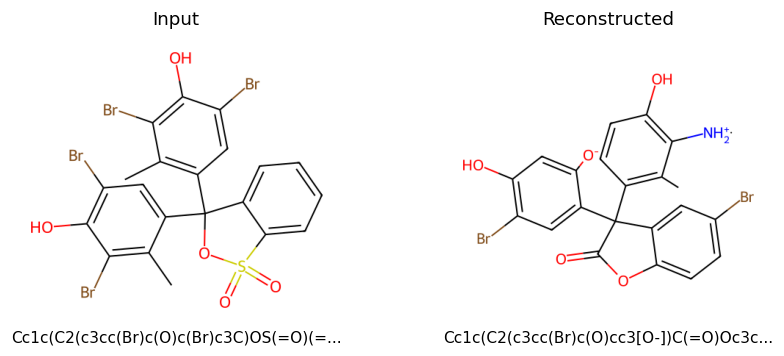

Input SMILES: Cc1c(C2(c3cc(Br)c(O)c(Br)c3C)OS(=O)(=O)c3ccccc32)cc(Br)c(O)c1Br
Reconstructed SMILES: Cc1c(C2(c3cc(Br)c(O)cc3[O-])C(=O)Oc3ccc(Br)cc32)ccc(O)c1[NH2+]


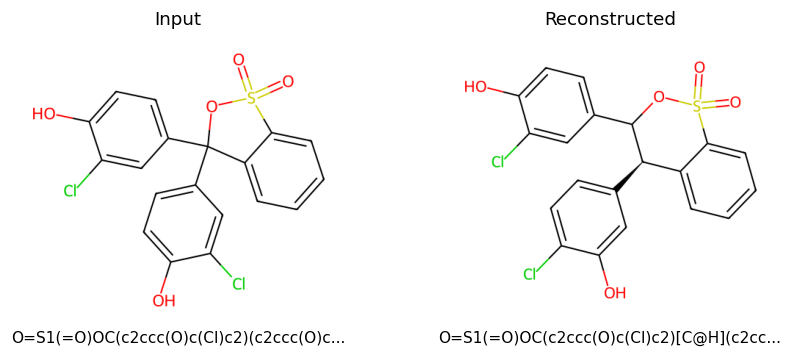

Input SMILES: O=S1(=O)OC(c2ccc(O)c(Cl)c2)(c2ccc(O)c(Cl)c2)c2ccccc21
Reconstructed SMILES: O=S1(=O)OC(c2ccc(O)c(Cl)c2)[C@H](c2ccc(Cl)c(O)c2)c2ccccc21


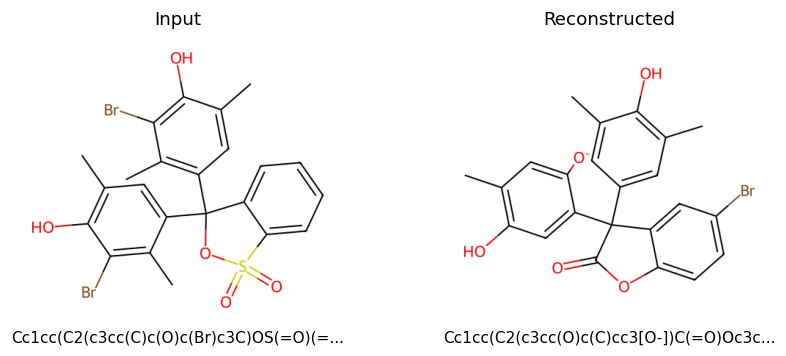

Input SMILES: Cc1cc(C2(c3cc(C)c(O)c(Br)c3C)OS(=O)(=O)c3ccccc32)c(C)c(Br)c1O
Reconstructed SMILES: Cc1cc(C2(c3cc(O)c(C)cc3[O-])C(=O)Oc3ccc(Br)cc32)cc(C)c1O


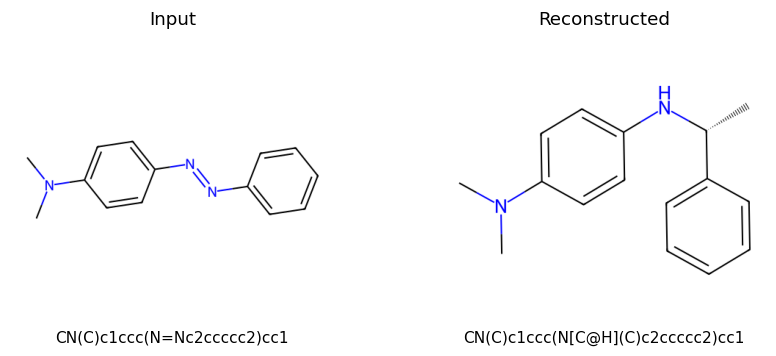

Input SMILES: CN(C)c1ccc(N=Nc2ccccc2)cc1
Reconstructed SMILES: CN(C)c1ccc(N[C@H](C)c2ccccc2)cc1


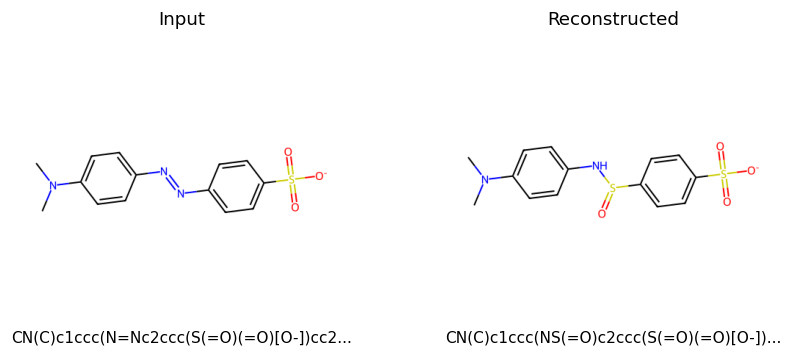

Input SMILES: CN(C)c1ccc(N=Nc2ccc(S(=O)(=O)[O-])cc2)cc1
Reconstructed SMILES: CN(C)c1ccc(NS(=O)c2ccc(S(=O)(=O)[O-])cc2)cc1


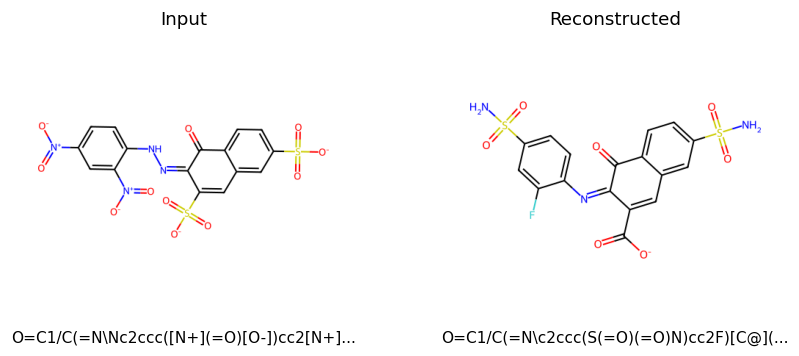

Input SMILES: O=C1/C(=N\Nc2ccc([N+](=O)[O-])cc2[N+](=O)[O-])C(S(=O)(=O)[O-])=Cc2cc(S(=O)(=O)[O-])ccc21
Reconstructed SMILES: O=C1/C(=N\c2ccc(S(=O)(=O)N)cc2F)[C@](C(=O)[O-])=C\c2cc(S(=O)(=O)N)ccc21


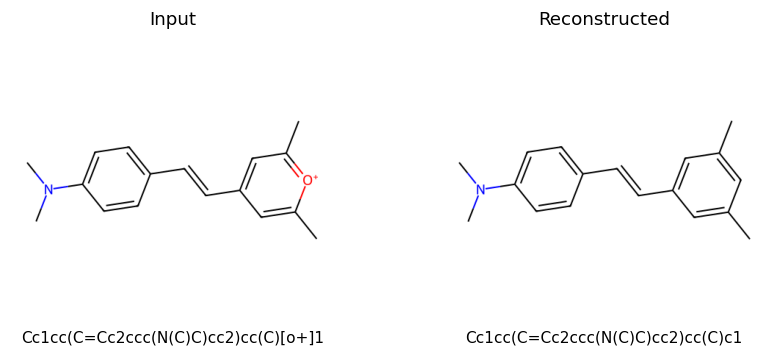

Input SMILES: Cc1cc(C=Cc2ccc(N(C)C)cc2)cc(C)[o+]1
Reconstructed SMILES: Cc1cc(C=Cc2ccc(N(C)C)cc2)cc(C)c1


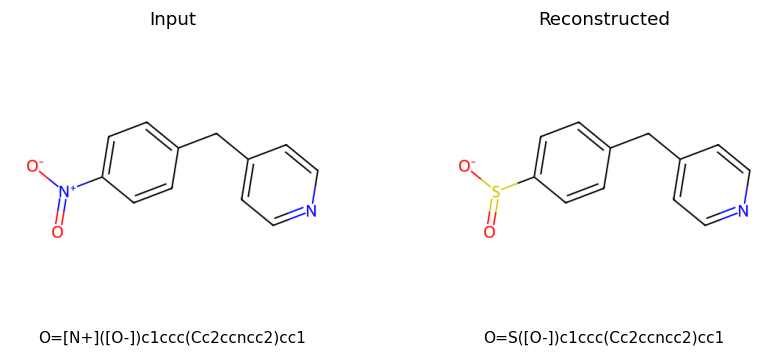

Input SMILES: O=[N+]([O-])c1ccc(Cc2ccncc2)cc1
Reconstructed SMILES: O=S([O-])c1ccc(Cc2ccncc2)cc1


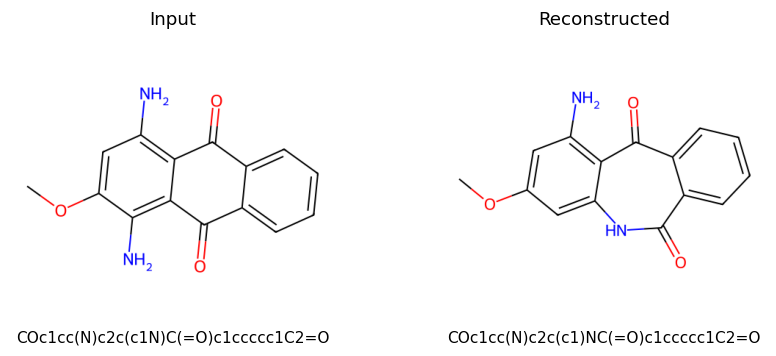

Input SMILES: COc1cc(N)c2c(c1N)C(=O)c1ccccc1C2=O
Reconstructed SMILES: COc1cc(N)c2c(c1)NC(=O)c1ccccc1C2=O


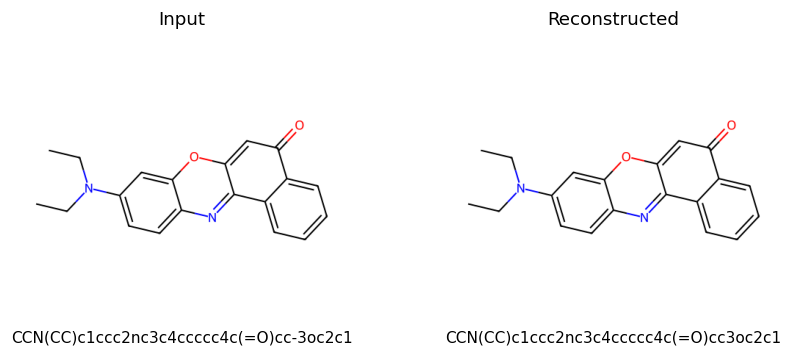

Input SMILES: CCN(CC)c1ccc2nc3c4ccccc4c(=O)cc-3oc2c1
Reconstructed SMILES: CCN(CC)c1ccc2nc3c4ccccc4c(=O)cc3oc2c1


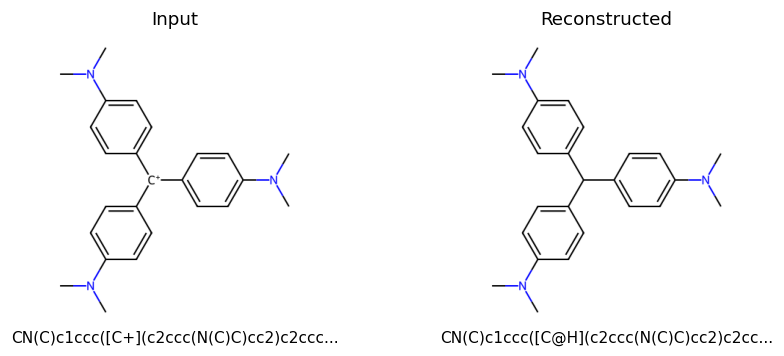

Input SMILES: CN(C)c1ccc([C+](c2ccc(N(C)C)cc2)c2ccc(N(C)C)cc2)cc1
Reconstructed SMILES: CN(C)c1ccc([C@H](c2ccc(N(C)C)cc2)c2ccc(N(C)C)cc2)cc1


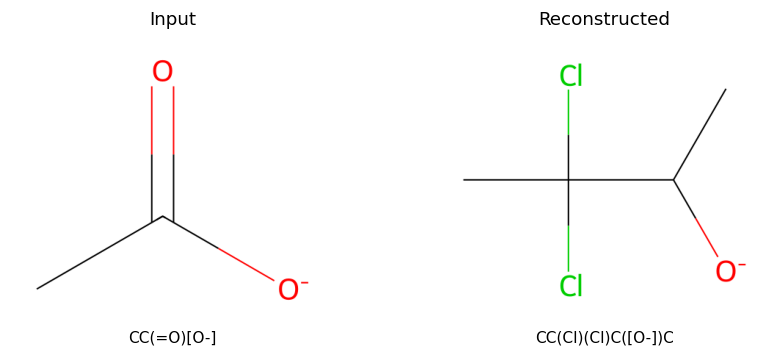

Input SMILES: CC(=O)[O-]
Reconstructed SMILES: CC(Cl)(Cl)C([O-])C


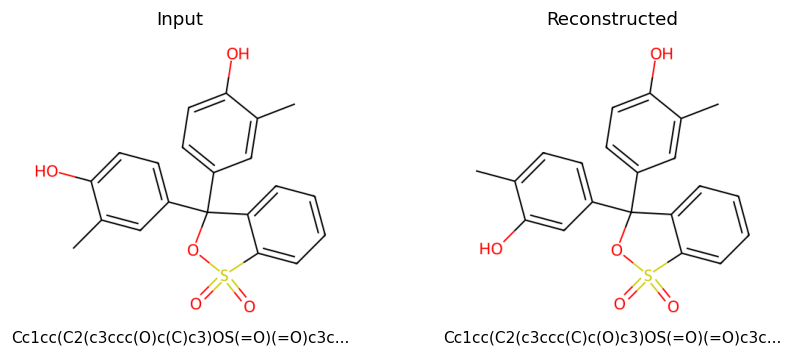

Input SMILES: Cc1cc(C2(c3ccc(O)c(C)c3)OS(=O)(=O)c3ccccc32)ccc1O
Reconstructed SMILES: Cc1cc(C2(c3ccc(C)c(O)c3)OS(=O)(=O)c3ccccc32)ccc1O


In [6]:
# Collect novel dye reconstructions (valid, lev > 0) and visualize in 3D
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from IPython.display import display



novel_dyes_df = ( df_rec.loc[ (df_rec["valid"].str.lower() == "yes") & (df_rec["lev"] > 0), ["input", "reconstructed"], ] .dropna() .drop_duplicates(subset="reconstructed"))
print(f"Found {len(novel_dyes_df)} novel dye reconstructions with lev > 0.")

def display_novel_dye_2d(df_subset=None, image_size=(440, 400), dpi=110, caption_chars=40):
    """Render side-by-side 2D depictions comparing input vs reconstruction."""
    data = novel_dyes_df if df_subset is None else df_subset
    if data is None or len(data) == 0:
        print("No novel dyes to display.")
        return

    def _truncate_caption(smiles, limit):
        if limit is None or limit >= len(smiles):
            return smiles
        if limit <= 3:
            return smiles[:limit]
        return smiles[: max(limit - 3, 0)] + "..."

    for row in data.itertuples(index=False):
        input_mol = Chem.MolFromSmiles(row.input)
        recon_mol = Chem.MolFromSmiles(row.reconstructed)

        if input_mol is None or recon_mol is None:
            missing = "input" if input_mol is None else "reconstructed"
            print(f"Skipping pair: unable to parse {missing} SMILES.")
            continue

        img_input = Draw.MolToImage(input_mol, size=image_size)
        img_recon = Draw.MolToImage(recon_mol, size=image_size)

        width = image_size[0] * 2 / dpi
        height = image_size[1] / dpi
        fig, axes = plt.subplots(1, 2, figsize=(width, height), dpi=dpi)

        axes[0].imshow(img_input)
        axes[0].set_title("Input")
        axes[0].axis("off")
        axes[0].text( 0.5, -0.01, _truncate_caption(row.input, caption_chars), transform=axes[0].transAxes, ha="center", va="top", fontsize=10, wrap=True)

        axes[1].imshow(img_recon)
        axes[1].set_title("Reconstructed")
        axes[1].axis("off")
        axes[1].text( 0.5, -0.01, _truncate_caption(row.reconstructed, caption_chars), transform=axes[1].transAxes, ha="center", va="top", fontsize=10, wrap=True)

        plt.tight_layout()
        fig.subplots_adjust(bottom=0.2)
        display(fig)
        plt.close(fig)

        print("Input SMILES: {inp}\nReconstructed SMILES: {rec}".format( inp=row.input, rec=row.reconstructed))

# Visualize the filtered dye reconstructions in 2D.
display_novel_dye_2d()
